In [1]:
import os
import mlflow
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
import numpy as np

import pandas as pd
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")
import argparse

In [10]:
dataset_name = "flowers102"
graph_type = "accuracy"

In [3]:
def get_color(value):
    if value > 0.5:
        return "white"
    else:
        return "black"

Traceback (most recent call last):
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 882, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 694, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
  File "/mnt/stud/home/jcheng/miniconda3/envs/scikit-activeml/lib/python3.10/site-packages/mlflow/uti

Badge
0
b
/mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking/291462985889780911/badd0542490c4c1bb655a5cde50d2c35/artifacts/result.csv
True
/mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking/291462985889780911/376d3689863647c3979249ed3096f436/artifacts/result.csv
True
/mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking/291462985889780911/e1786a7a3d6549fc91638444e824d03e/artifacts/result.csv
True
/mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking/291462985889780911/0abe8b20aa0e4f4fa8aab397ac2bfda7/artifacts/result.csv
True
/mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking/291462985889780911/74c2c413d57d425b93ca20a1160d9039/artifacts/result.csv
True
TypiClust
1
g
/mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking/291462985889780911/9845db1f5ca540b588f204482f1d1b81/artifacts/result.csv
True
/mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking/291462985889780911/1b1a36bd39a04a788d618d588b15f10f/artifact

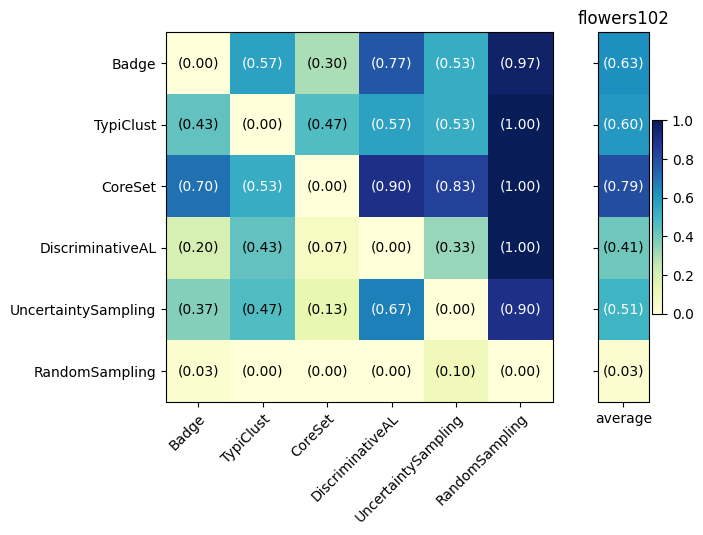

In [11]:
batch_size = 16

# mlflow.set_tracking_uri(uri="/Users/chengjiaying/scikit-activeml/tutorials/tracking")
mlflow.set_tracking_uri(uri="file:///mnt/stud/home/jcheng/scikit-activeml/tutorials/mlflow_tracking")

experiment = mlflow.get_experiment_by_name("Evaluation-Active-Learning-Params")
df = mlflow.search_runs(experiment_ids=experiment.experiment_id, output_format="pandas")

df = df[['params.dataset', 'params.qs', 'params.batch_size', 'params.n_cycles', 'params.seed', 'artifact_uri']]

df = df.loc[df['params.dataset'] == dataset_name]
query_stragies = df['params.qs'].unique()
colors = ["b", "g", "r", "c", "m", "k"]
result_dict = {}

for idx, qs_name in enumerate(query_stragies):
    print(qs_name)
    print(idx)
    print(colors[idx])
    color = colors[idx]
    df_qs = df.loc[df['params.qs'] == qs_name]
    r = []
    for idx_ti, row in df_qs.iterrows():
        artifact = os.path.join(row.artifact_uri, 'result.csv')
        artifact = artifact.split("file://")[1]
        print(artifact)
        print(os.path.exists(artifact))
        if os.path.exists(artifact):
            result_qs = pd.read_csv(artifact, index_col=0)
            r.append(result_qs)
    results = pd.concat(r)
    result = results.groupby(['step'])[graph_type].agg(['mean', 'std']).set_axis(['mean', 'std'], axis=1)
    result_mean = result['mean'].to_numpy()
    result_dict[idx] = result_mean

heat_map_numpy = np.zeros(shape=(6,6))

for i in range(6):
    for j in range(6):
        if i == j:
            continue
        win_counter = 0
        i_algo_result = result_dict[i]
        j_algo_result = result_dict[j]
        for l in range(len(i_algo_result)):
            if i_algo_result[l] > j_algo_result[l]:
                win_counter += 1
        heat_map_numpy[i, j] = win_counter / (len(i_algo_result))

heat_map_sum = np.sum(heat_map_numpy, axis=1).reshape(-1, 1) / 5

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [6,1]})
a1 = axs[0].imshow(heat_map_numpy, cmap="YlGnBu",
                   vmin=0.0, vmax=1.0, aspect='auto',
                   interpolation='nearest')
a2 = axs[1].imshow(heat_map_sum, cmap="YlGnBu",
                   vmin=0.0, vmax=1.0, aspect='auto',
                   interpolation='nearest')

axs[0].set_xticks(np.arange(len(query_stragies)), labels=query_stragies)
plt.setp(axs[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
axs[0].set_yticks(np.arange(len(query_stragies)), labels=query_stragies)

axs[1].set_yticks(np.arange(len(query_stragies)), labels=query_stragies)
axs[1].set_xticks(np.arange(1), ['average'])

plt.colorbar(a2)

for i in range(6):
    for j in range(6):
        text = axs[0].text(j, i, f"({heat_map_numpy[i, j]:.2f})",
                       ha="center", va="center", color=get_color(heat_map_numpy[i, j]))

for i in range(6):
    text1 = axs[1].text(0, i, f"({heat_map_sum[i, 0]:.2f})",
                   ha="center", va="center", color=get_color(heat_map_sum[i, 0]))

plt.title(dataset_name, loc="center")

output_path = f'/mnt/stud/home/jcheng/scikit-activeml/tutorials/result_param/{dataset_name}_heatmap.pdf'
plt.savefig(output_path, bbox_inches="tight")